In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt

In [2]:
!pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import seaborn as sns
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [12]:
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240808/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30_s64/processed/tl_tf_multi_sarscov2-S-WIV04ref.csv_WIV04.csv")
#perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240710/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_cls_hybrid_attn_fnn_2l_lr1e-4/aligned_msl128_s64/processed/tl_tf_multi_coronaviridae_s_uniref90_sars_cov_2_aligned.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    return df

In [7]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [8]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [9]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [13]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)


In [14]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred
0,0.000079,0.010840,0.326391,0.000130,0.000052,0.012989,0.649467,0.000053,WIV04,Human,S,1054,Z,0.000394,0.000394,Human,Human
1,0.000078,0.010797,0.326869,0.000130,0.000052,0.013023,0.648998,0.000053,WIV04,Human,G,565,J,-0.000076,0.000076,Human,Human
2,0.000068,0.009892,0.328357,0.000116,0.000045,0.012591,0.648886,0.000046,WIV04,Human,V,511,K,-0.000188,0.000188,Human,Human
3,0.000077,0.010710,0.326888,0.000128,0.000051,0.012963,0.649131,0.000052,WIV04,Human,Y,836,Z,0.000057,0.000057,Human,Human
4,0.000079,0.011037,0.323989,0.000129,0.000052,0.012813,0.651848,0.000052,WIV04,Human,R,681,D,0.002774,0.002774,Human,Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,0.000077,0.010310,0.333376,0.000132,0.000051,0.013520,0.642479,0.000054,WIV04,Human,I,67,B,-0.006595,0.006595,Human,Human
31822,0.000078,0.010692,0.327615,0.000129,0.000051,0.013049,0.648333,0.000053,WIV04,Human,A,1025,T,-0.000741,0.000741,Human,Human
31823,0.000078,0.010752,0.326848,0.000129,0.000052,0.012992,0.649097,0.000052,WIV04,Human,S,942,A,0.000023,0.000023,Human,Human
31824,0.000079,0.010875,0.326254,0.000130,0.000052,0.012996,0.649561,0.000053,WIV04,Human,F,31,D,0.000487,0.000487,Human,Human


In [15]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_pos"].isna()]

# Overview

### Distribution of Human class difference

In [18]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [19]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 1 (0.0031420850876641743)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.134313 -0.123494      1    0.003142
1  -0.123494 -0.112675      0    0.000000
2  -0.112675 -0.101856      0    0.000000
3  -0.101856 -0.091037      3    0.009426
4  -0.091037 -0.080218      4    0.012568
5  -0.080218 -0.069399     15    0.047131
6  -0.069399 -0.058580     50    0.157104
7  -0.058580 -0.047761     40    0.125683
8  -0.047761 -0.036942     49    0.153962
9  -0.036942 -0.026123    121    0.380192
10 -0.026123 -0.015304    407    1.278829
11 -0.015304 -0.004485   2657    8.348520
12 -0.004485  0.006334  26250   82.479734
13  0.006334  0.017153   1831    5.753158
14  0.017153  0.027972    291    0.914347
15  0.027972  0.038791     81    0.254509
16  0.038791  0.049610     18    0.056558
17  0.049610  0.060429      3    0.009426
18  0.060429  0.071248      2    0.006284
19  0.071248  0.082067      3   

<Figure size 432x288 with 0 Axes>

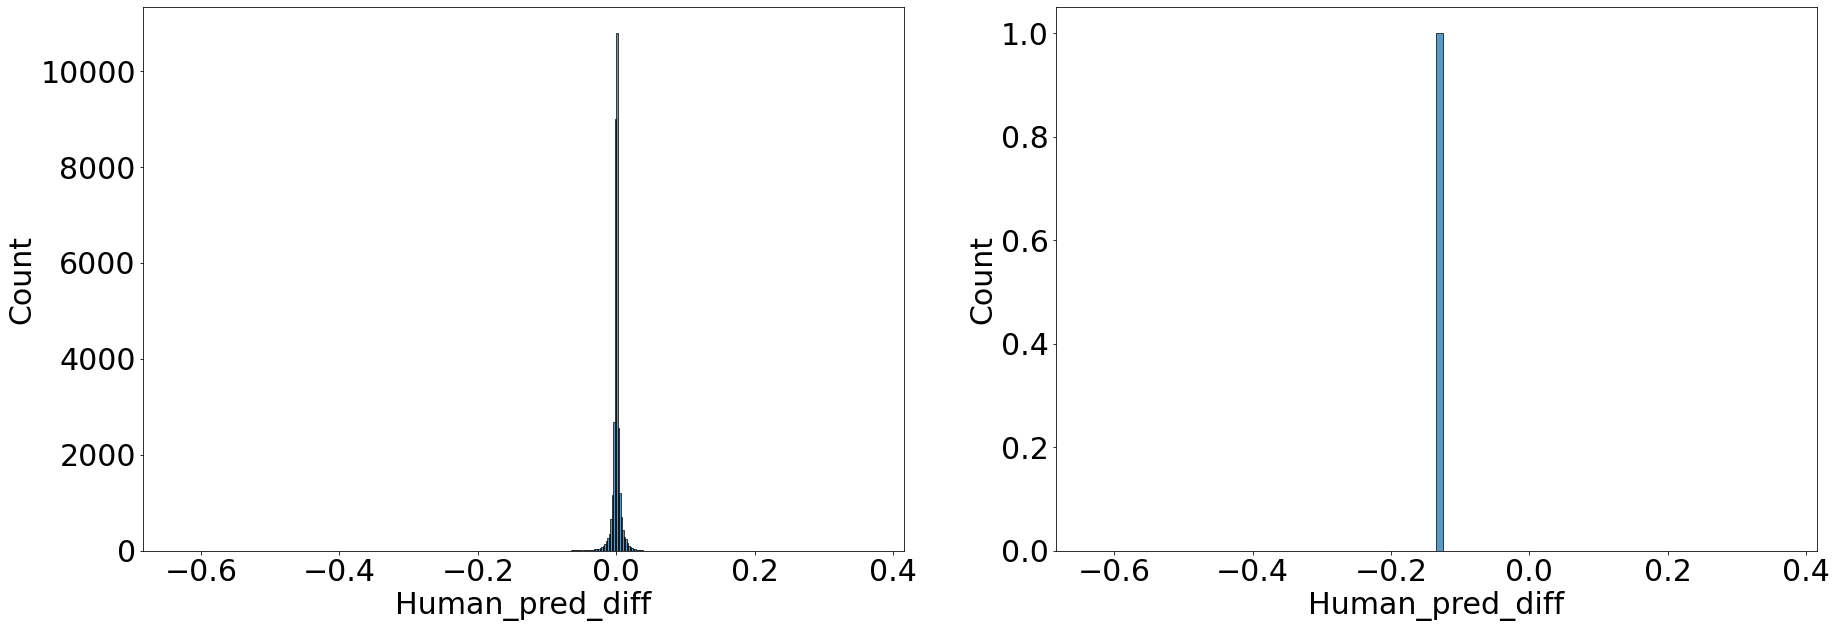

In [20]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

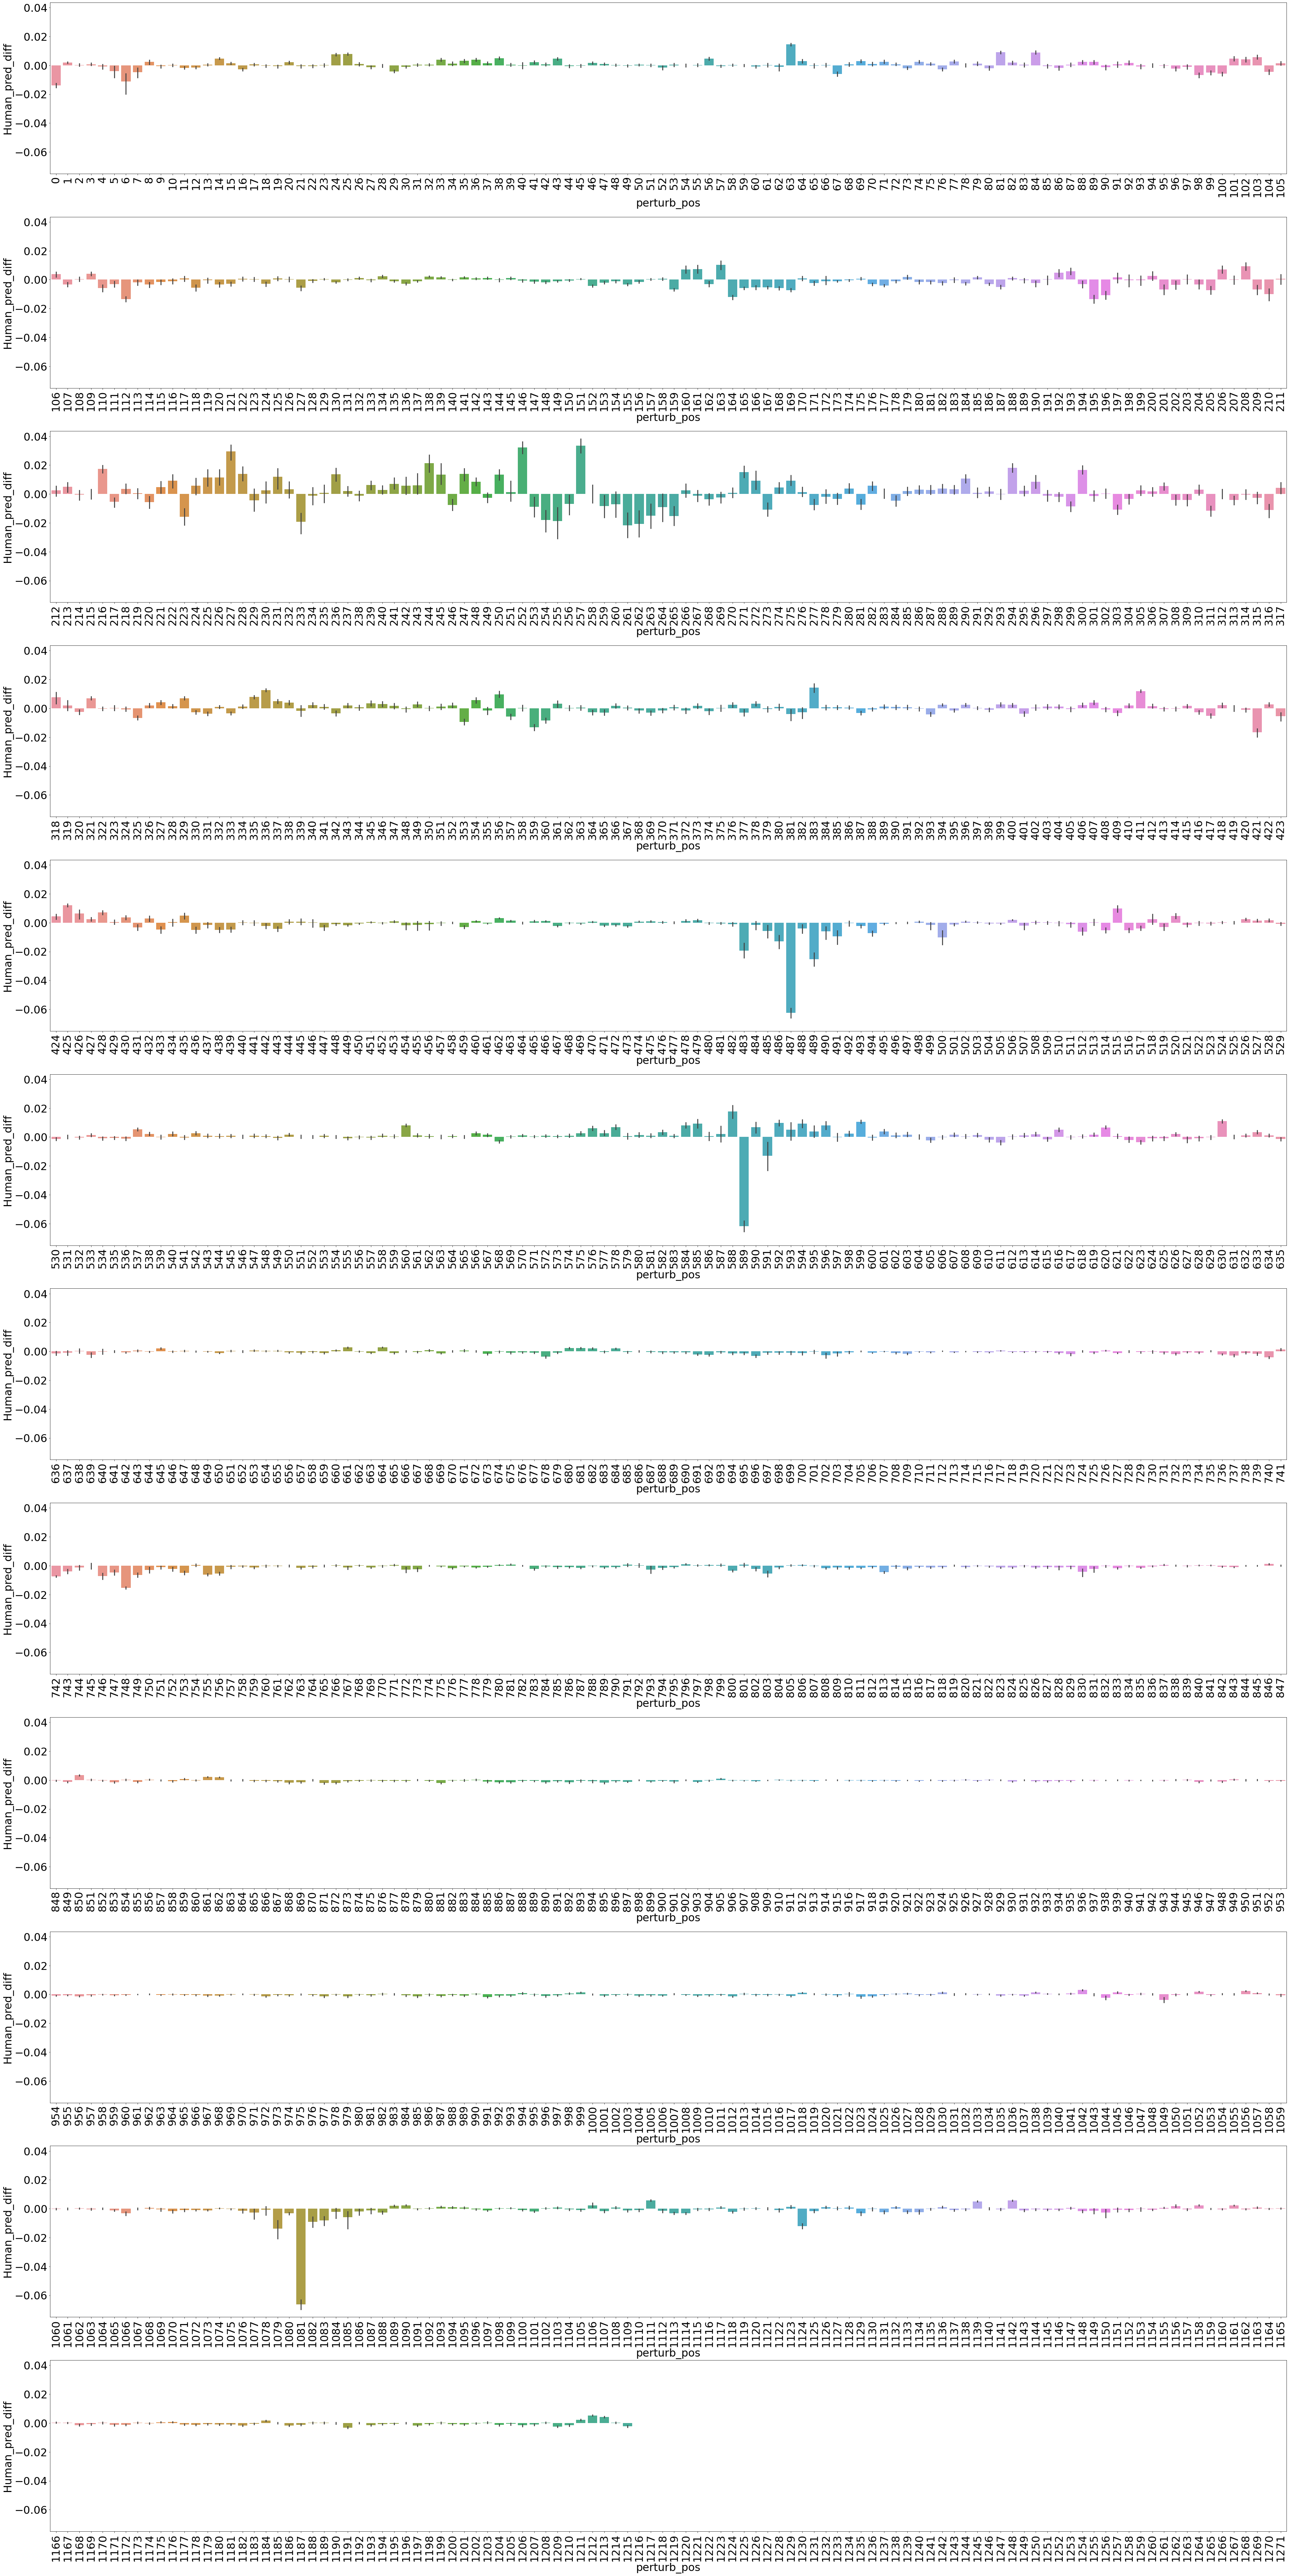

In [22]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 12
fig, axs = plt.subplots(n, 1, figsize=(50, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(sorted(perturbed_output_df["perturb_pos"].unique())), n)

for i in range(n):
    sns.barplot(perturbed_output_df[perturbed_output_df["perturb_pos"].isin(bins[i])], x="perturb_pos", y=pred_diff_col, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: mean=0 and variance=0

In [23]:
mean_std_df = perturbed_output_df.groupby("perturb_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_pos"].isin(cut_off_pos)]
cut_off_pos_1 = set(cut_off_df_1["perturb_pos"].unique())
len(cut_off_pos_1)


1216

<Figure size 432x288 with 0 Axes>

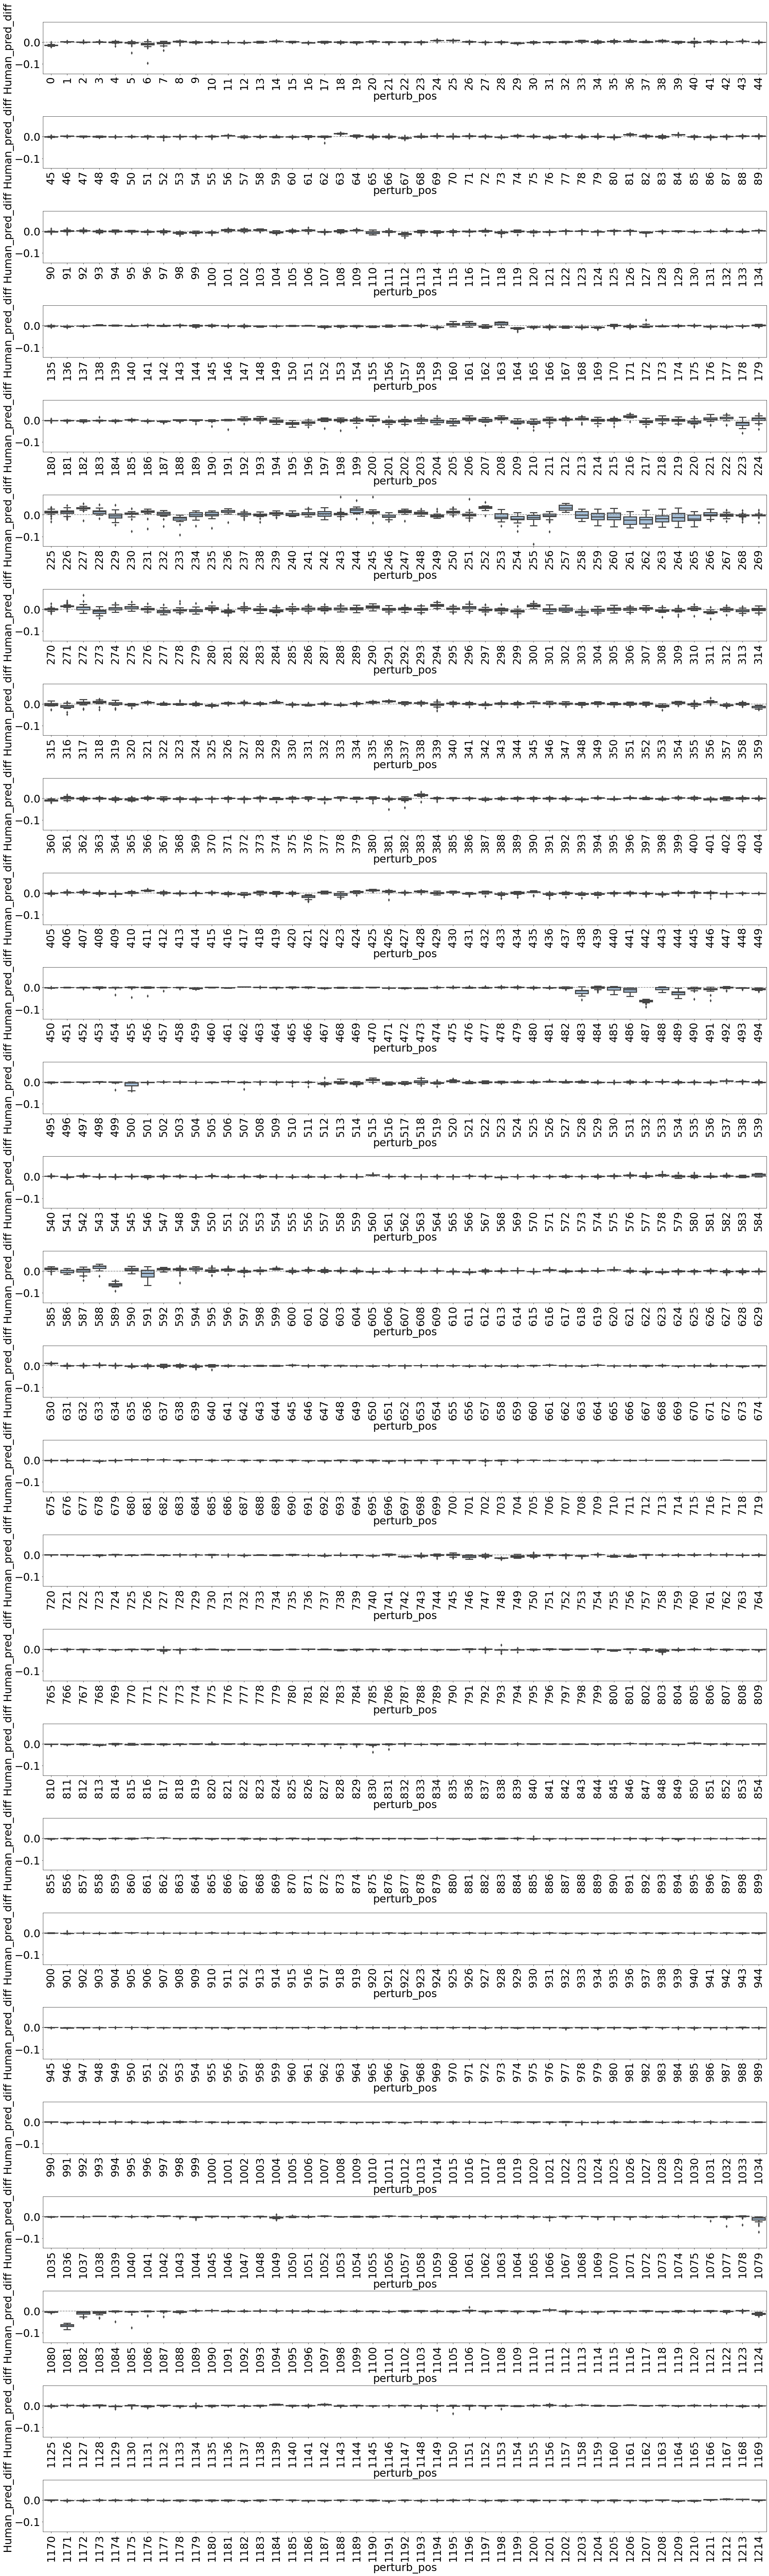

In [25]:
plt.clf()
n = 27
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(n, 1, figsize=(30, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(cut_off_pos_1), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_1[cut_off_df_1["perturb_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [23]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1201
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 0
1 intersection 2: 0
1 minus 2: 1201
2 minus 1: 0
is 2 subset of 1: True


ValueError: min() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

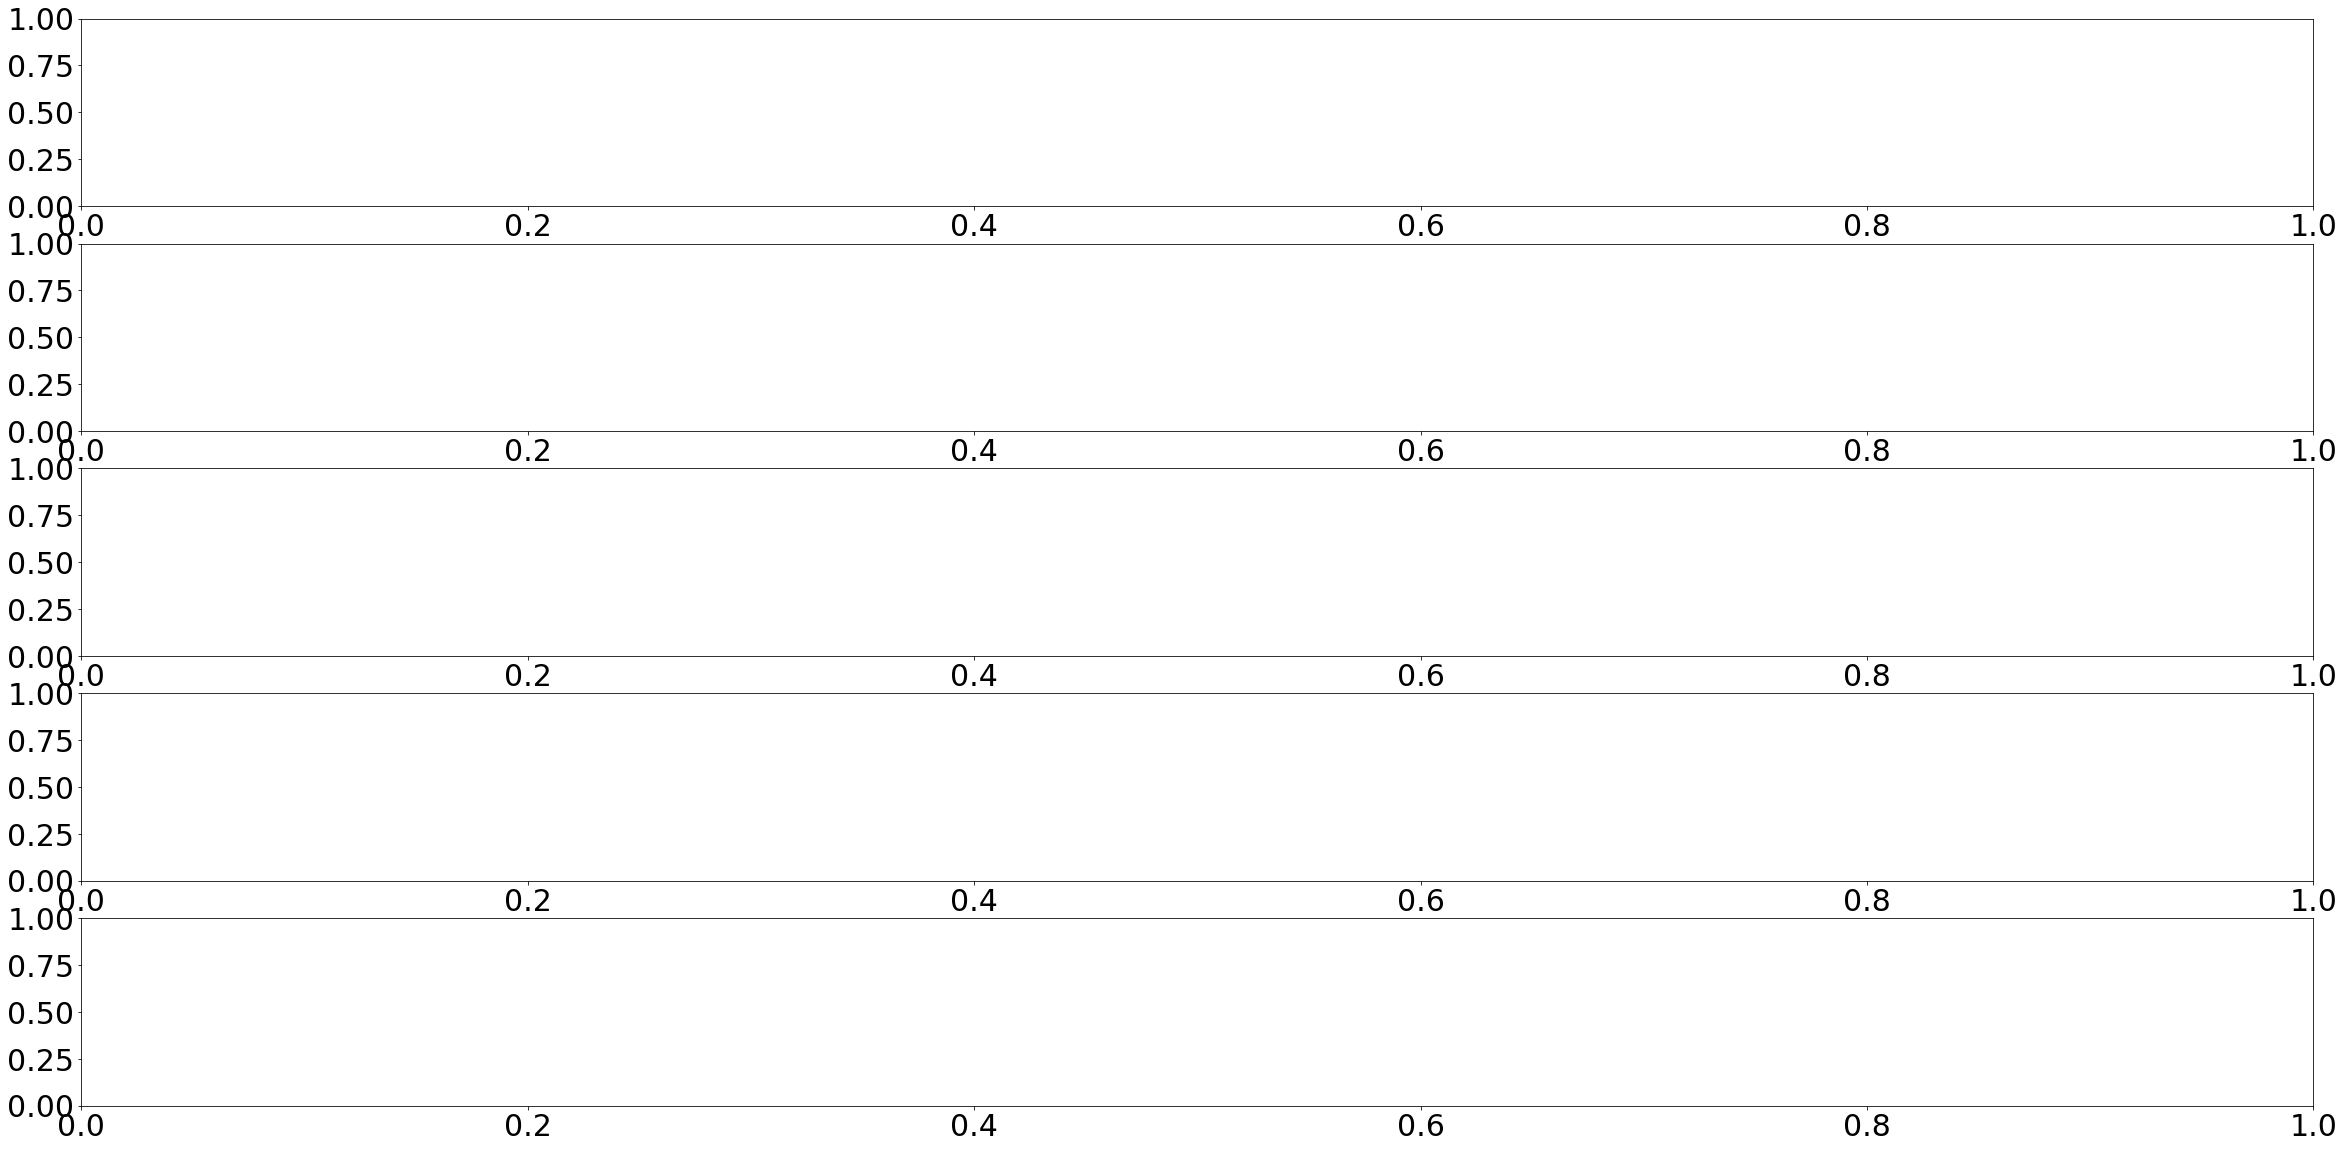

In [24]:
plt.clf()
n = 5
fig, axs = plt.subplots(n, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")

plt.tight_layout(pad=.1)
plt.show()


## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [25]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No non overlapping boxes found


<Figure size 432x288 with 0 Axes>

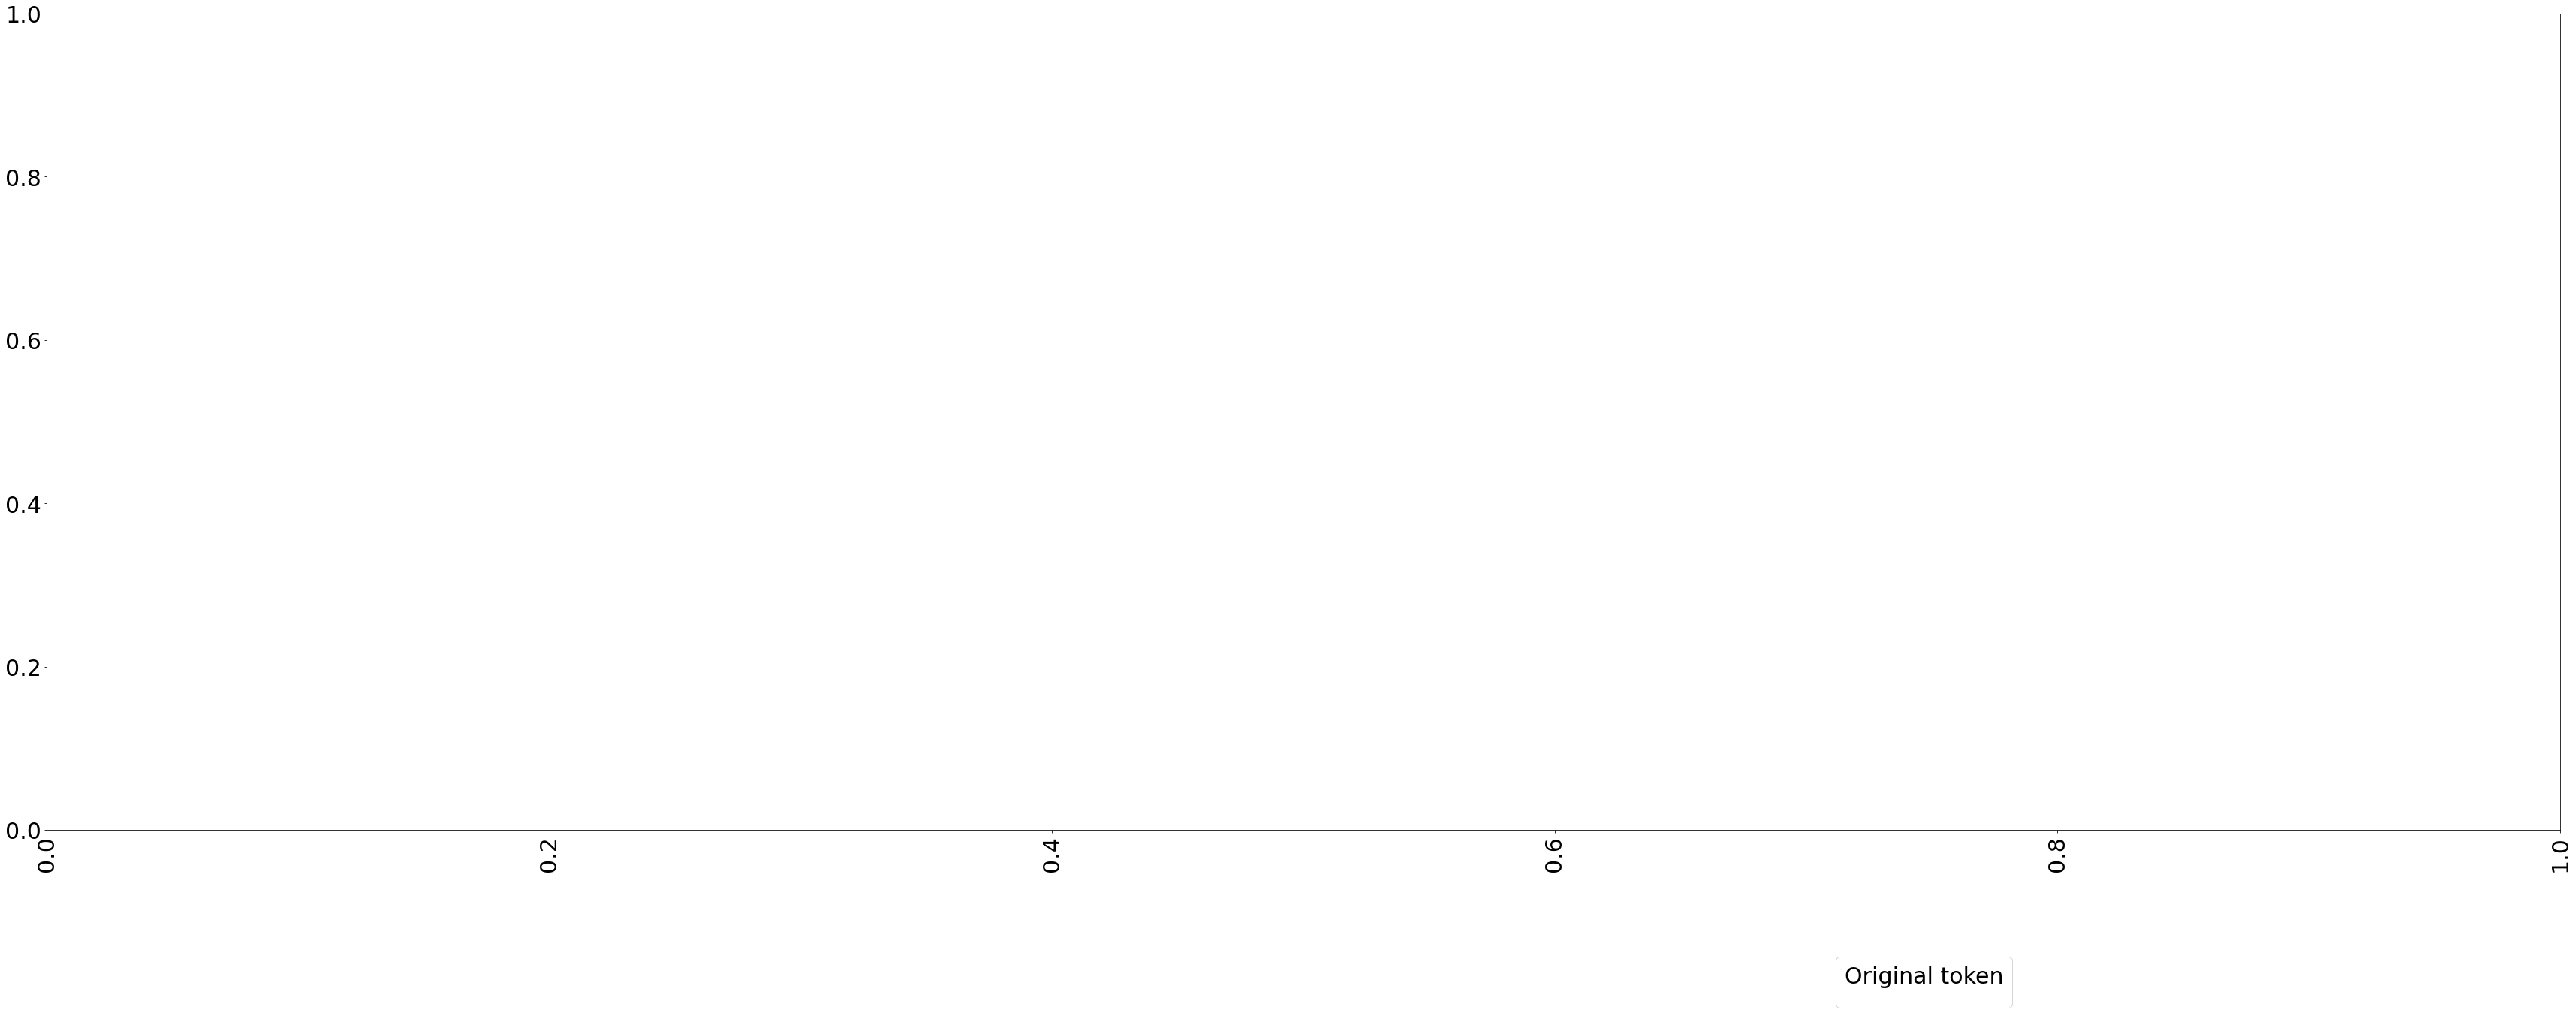

In [26]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [27]:
annotate_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos,perturbation_id


### Mutations with new token NOT = X

In [28]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (0, 19)
Number of unique mutations = 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No non overlapping boxes found


<Figure size 432x288 with 0 Axes>

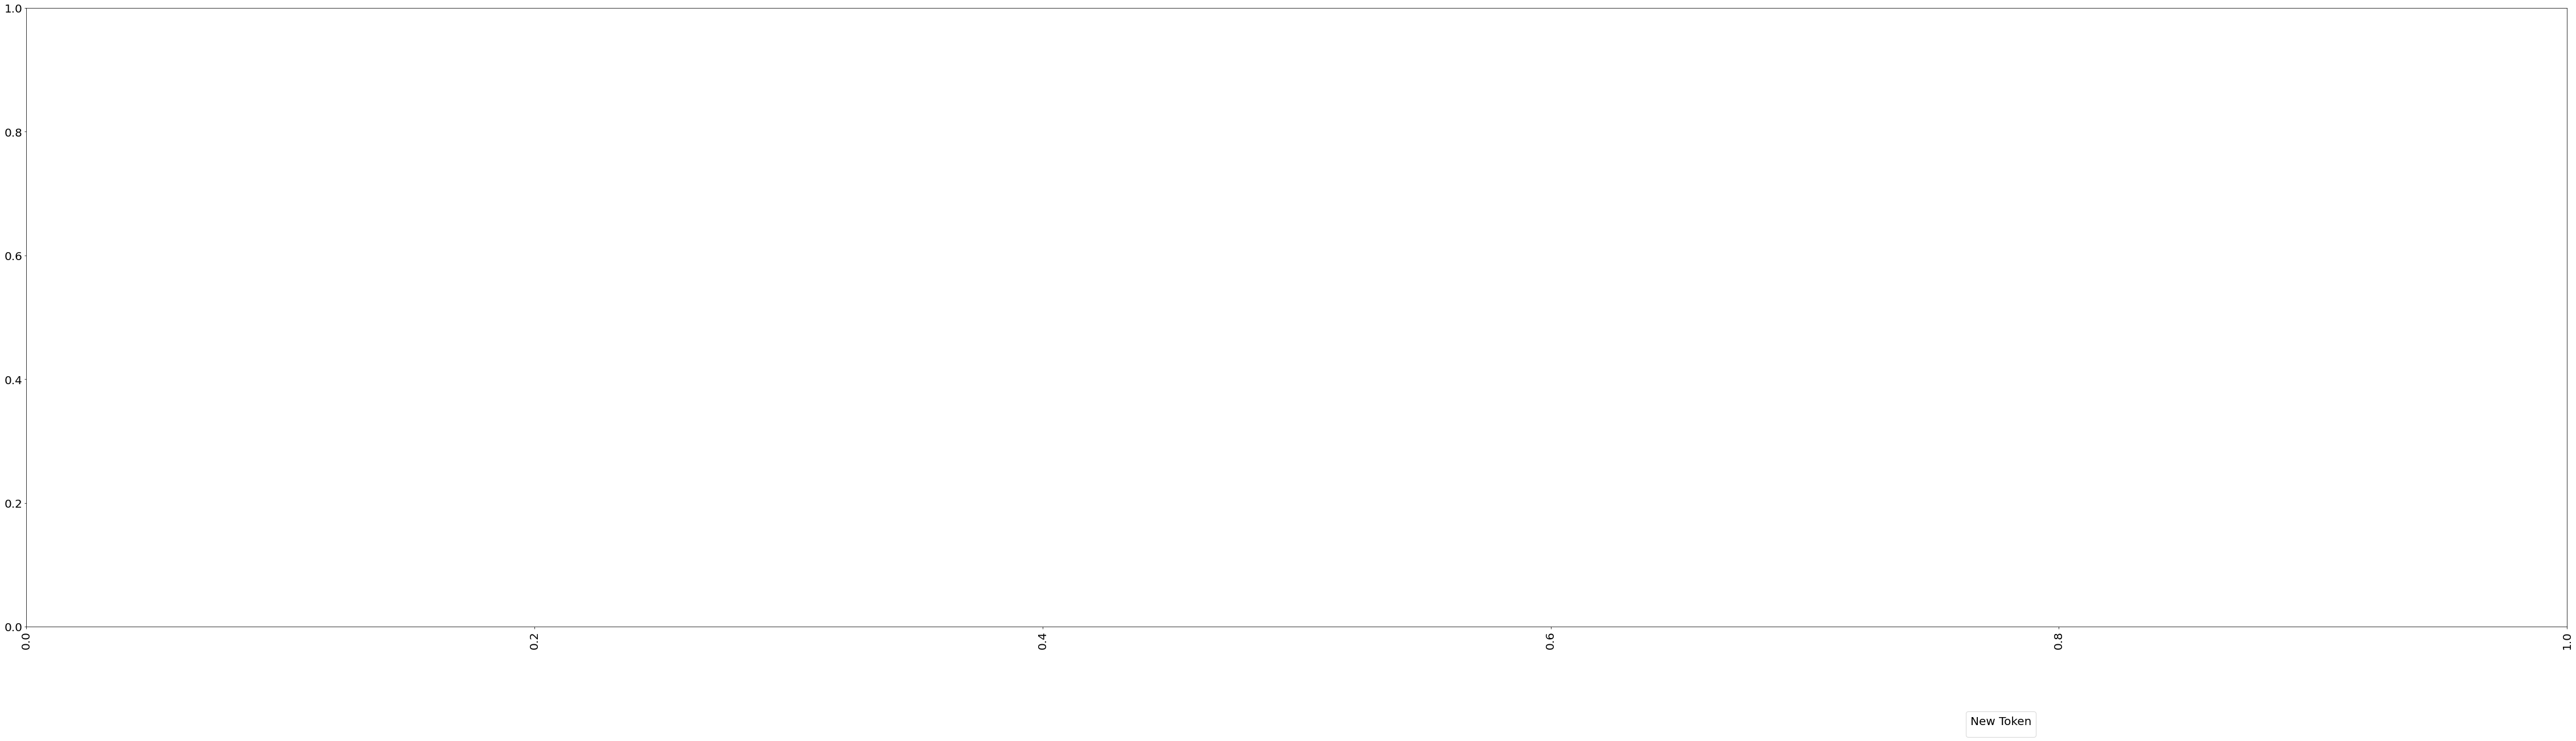

In [29]:
plt.clf()
plt.figure(figsize=(80, 20))
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [30]:
cut_off_df_2["perturbation_id"].nunique()

0

ValueError: min() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

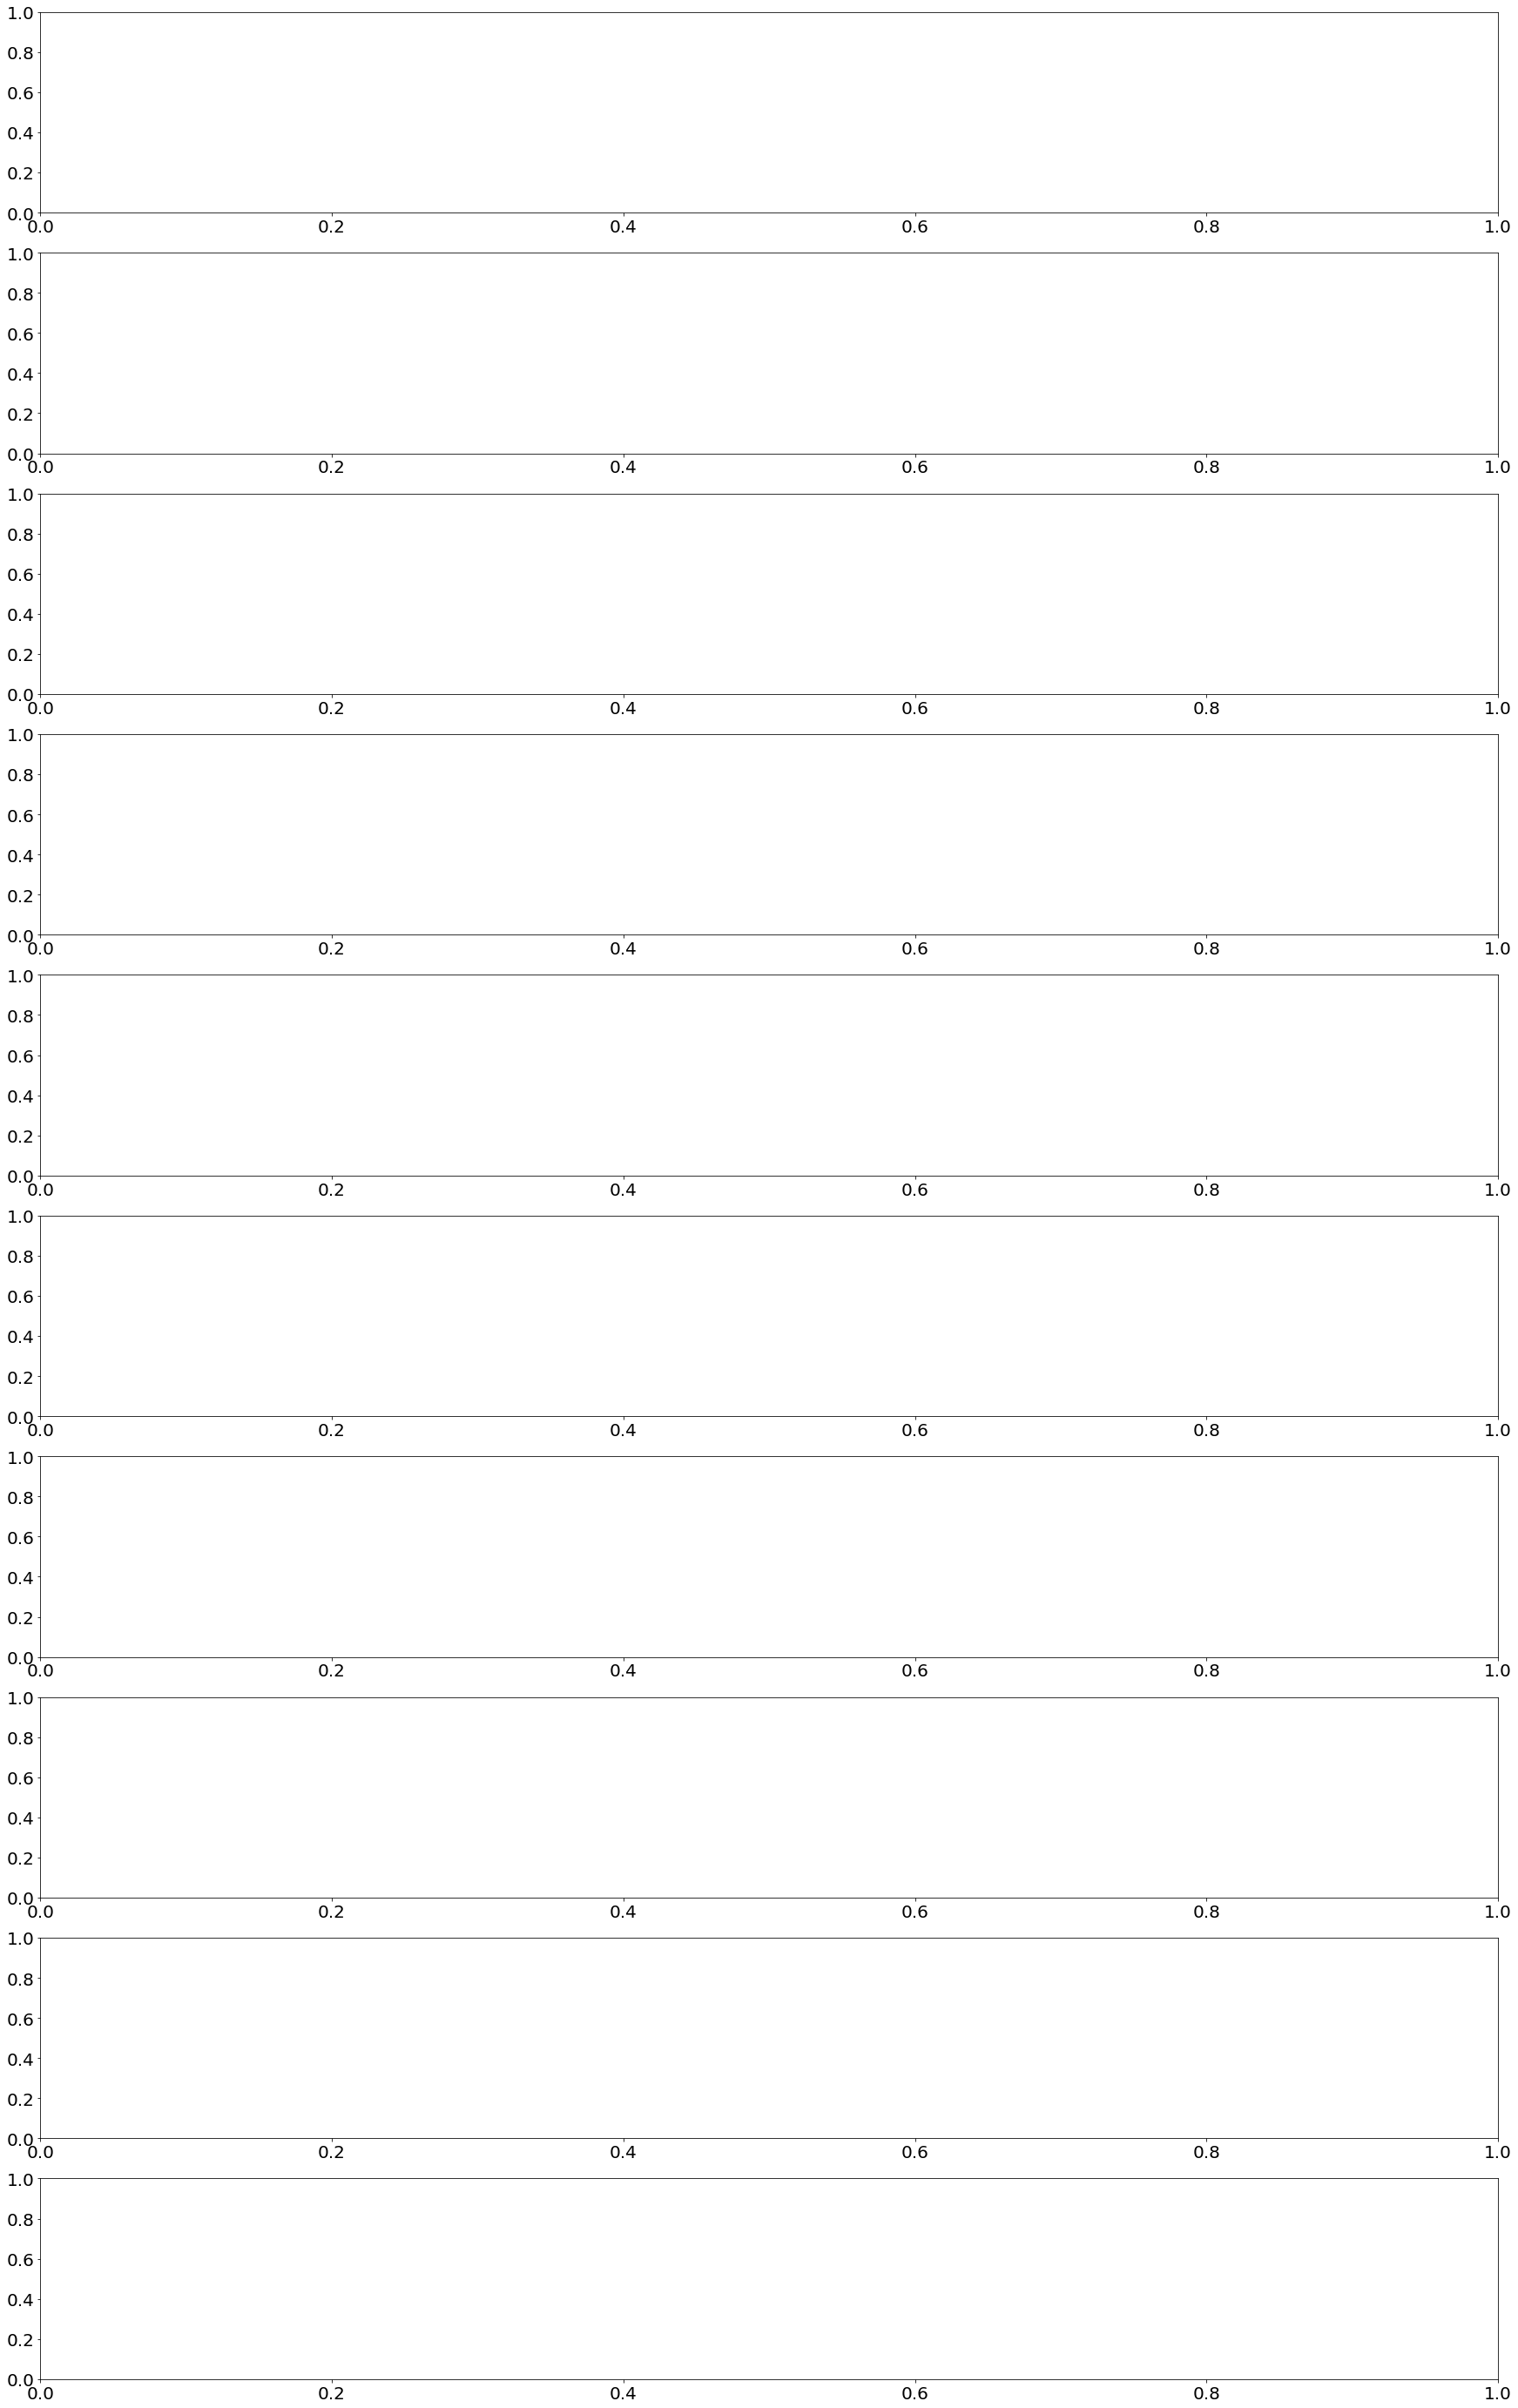

In [31]:
plt.clf()
n = 10
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(n, 1, figsize=(30, 50), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), n)

for i in range(n):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[i], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [32]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_grouped_filtered.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
#s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,spike_mutations,pango_lineage,variant_count
0,A222V,['B.1.177'],1
1,A264D,"['JN.1', 'JN.4']",2
2,A27S,"['BA.2', 'BA.2.12.1', 'BA.2.75', 'JN.1', 'BA.4...",27
3,A475V,"['XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'GW.5.1.1', ...",5
4,A570D,['B.1.1.7'],1
...,...,...,...
129,V83A,"['EG.5.1', 'XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'J...",16
130,W152C,"['B.1.427, B.1.429']",1
131,W152R,['BA.2.75'],1
132,Y248H,"['XBB.1.5', 'JD.1.1.1']",2


In [33]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

In [34]:
mutation_variant_heatmap_df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_filtered_heatmap.csv"))
mutation_variant_heatmap_df.set_index("spike_mutations", inplace=True)
mutation_variant_heatmap_df

,B.1.1.1.C37,B.1.1.28.1,B.1.1.28.2,B.1.1.28.3,B.1.1.318,B.1.1.7,B.1.177,B.1.214.2,B.1.351,B.1.375,...,HK.3.2,HV.1,JD.1.1,JD.1.1.1,JG.3,JN.1,JN.4,XBB,XBB.1,XBB.1.5
spike_mutations,,,,,,,,,,,,,,,,,,,,,
A222V,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A264D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
A27S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A475V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0
A570D,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V83A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0
W152C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W152R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["spike_mutations"])]

# s_mutations_df = s_mutations_df.merge(known_mutations_df[["perturbation_id", "label"]], on="perturbation_id")
# s_mutations_df

<Figure size 432x288 with 0 Axes>

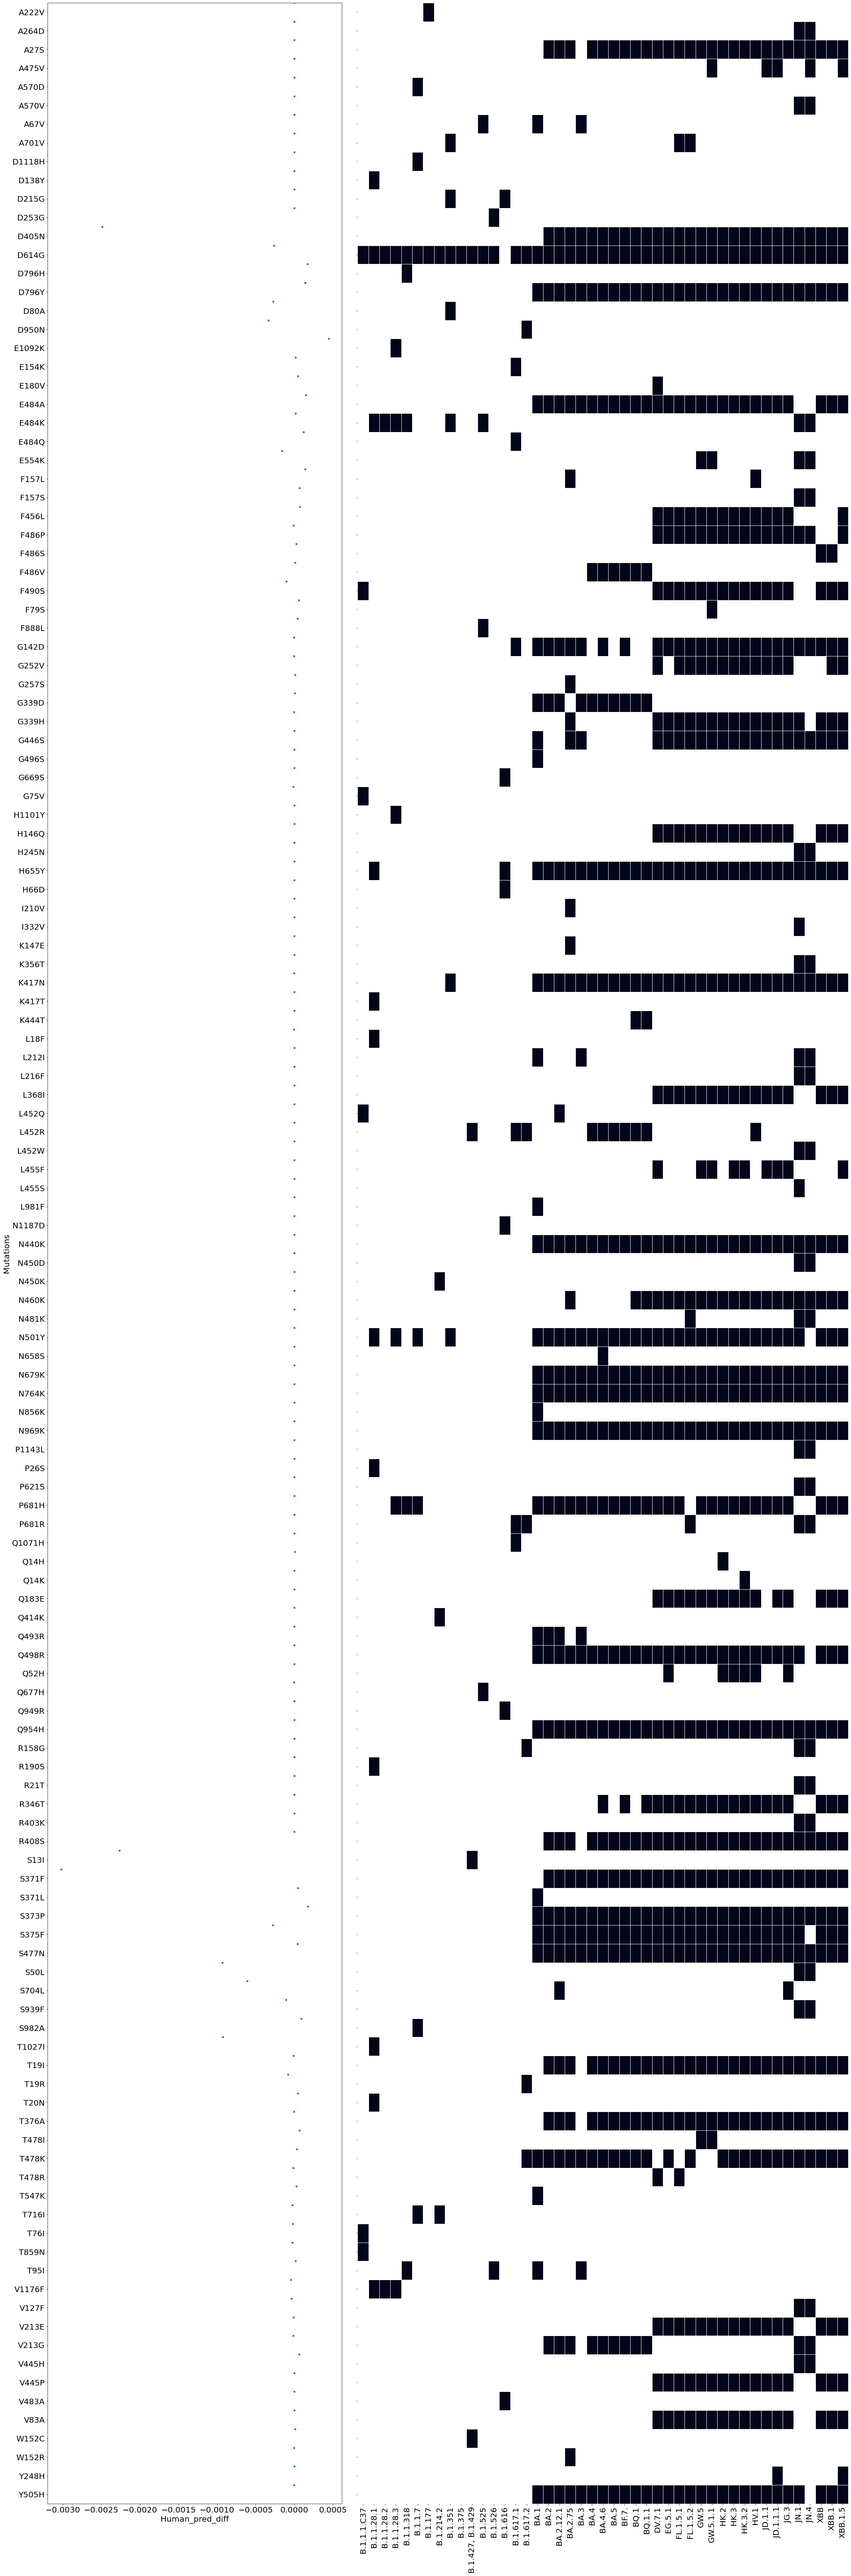

In [36]:
plt.clf()
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

fig, axs = plt.subplots(1, 2, figsize=(30, 90), sharex=False, sharey=True, gridspec_kw={'width_ratios': [.6, 1]})


sns.stripplot(data=known_mutations_df, y="perturbation_id", x="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["perturbation_id"].unique(), ax=axs[0])
    
axs[0].set_ylabel("Mutations")
    #axs.tick_params(axis='x', rotation=90)
sns.heatmap(mutation_variant_heatmap_df, linewidth=.5, ax=axs[1], cmap=sns.cm.rocket_r, cbar=False, vmin=0, vmax=1)
# plt.tight_layout(pad=.2)
axs[1].set_ylabel("")
plt.tight_layout()
plt.show()

### Identified and Known Mutations

In [37]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["spike_mutations"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 0
known_mutations = 134
intersection = set()
